In [1]:
from google.colab import drive
drive.mount("/content/drive")
import os
os.chdir("/content/drive/MyDrive/scnn-1st-paper")
%pip install dipy healpy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import math
import sys
import time

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import seaborn as sns
import torch

from models import SCNNModel
from sh import l_max, n_coeffs, sh

sns.set_theme()

if torch.cuda.is_available():
    device = "cuda"
    print(torch.cuda.get_device_name(0))
else:
    raise Exception("GPU not available")

Tesla T4


In [3]:
# Acquisition protocol

data_img = nib.load("data/test-subject/dwi.nii.gz")
data = data_img.get_fdata()
affine = data_img.affine
mask = nib.load("data/test-subject/brain_mask.nii.gz").get_fdata().astype(bool)

bvals = torch.tensor(np.loadtxt("data/test-subject/dwi.bval") / 1e3)
bvecs = torch.tensor(np.loadtxt("data/test-subject/dwi.bvec").T)

data /= np.nanmean(data[..., np.where(bvals == 0)], axis=-1)
idx = np.where(bvals > 0)[0]
mask *= ~np.any(np.isnan(data), axis=-1).astype(bool)
mask = torch.tensor(mask.astype(bool))
data = data[mask]
data = data[:, idx]
data = torch.tensor(data).squeeze().float()

idx = bvals > 0
bvals = bvals[idx]
bvecs = bvecs[idx]

bs = torch.unique(bvals)
n_shells = len(bs)
shell_idx_list = [torch.where(bvals == b)[0] for b in bs]
bvecs_list = [bvecs[bvals == b] for b in bs]

bvecs_isft_list = []
bvecs_sft_list = []
for bvecs in bvecs_list:
    thetas = torch.arccos(bvecs[:, 2])
    phis = torch.arctan2(bvecs[:, 1], bvecs[:, 0]) + math.pi
    bvecs_isft = torch.zeros((len(bvecs), n_coeffs), dtype=float)
    for l in range(0, l_max + 1, 2):
        for m in range(-l, l + 1):
            bvecs_isft[:, int(0.5 * l * (l + 1) + m)] = sh(l, m, thetas, phis)
    bvecs_isft_list.append(bvecs_isft)
    bvecs_sft = torch.zeros((n_coeffs, len(bvecs)), dtype=float)
    bvecs_sft[0:45] = (
        torch.linalg.pinv(bvecs_isft[:, 0:45].T @ bvecs_isft[:, 0:45])
        @ bvecs_isft[:, 0:45].T
    )
    bvecs_sft_list.append(bvecs_sft.float())

<ipython-input-3-935aae1eb7cb>:11: RuntimeWarning: invalid value encountered in true_divide
  data /= np.nanmean(data[..., np.where(bvals == 0)], axis=-1)


In [7]:
# Calculate maps

model = SCNNModel(2, 2, l_max).to(device)
model.load_state_dict(torch.load("scnn_weights_rot.pt"))
model.eval()

start = time.time()

data_sh = torch.zeros(len(data), n_shells, n_coeffs)
for i in range(n_shells):
    data_sh[:, i] = (
        bvecs_sft_list[i] @ data[:, shell_idx_list[i]].unsqueeze(2)
    ).squeeze()
data_sh = data_sh.to(device).float()

preds = torch.zeros(len(data), 2).to(device)
n_iter = int(1e4)
for i in range(0, len(data), n_iter):
    idx = torch.arange(i, i + n_iter)
    if i + n_iter > len(data):
        idx = torch.arange(i, len(data))
    with torch.no_grad():
        preds[idx] = model(data_sh[idx])
preds[:, 0] *= 3

print(time.time() - start)

maps = np.zeros(mask.shape + (2,))
maps[mask] = preds.detach().cpu()

nib.save(nib.Nifti1Image(maps, affine), "scnn_smt_maps.nii.gz")

8.289499282836914


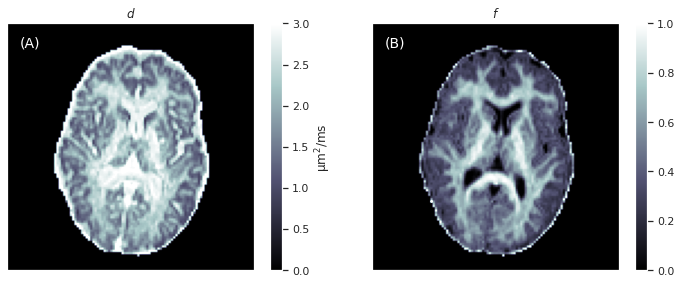

In [5]:
# Make figure

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
im = ax[0].imshow(np.rot90(maps[:, :, 32, 0]), vmin=0, vmax=3, cmap="bone")
plt.colorbar(im, label=r"μm$^2$/ms", ax=ax[0])
im = ax[1].imshow(np.rot90(maps[:, :, 32, 1]), vmin=0, vmax=1, cmap="bone")
plt.colorbar(im, ax=ax[1])
titles = [r"$d$", r"$f$"]
for i in range(2):
    ax[i].set_title(titles[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
labels = ["(A)", "(B)"]
for i in range(2):
    ax[i].text(
        0.05,
        0.95,
        labels[i],
        verticalalignment="top",
        horizontalalignment="left",
        color="white",
        transform=ax[i].transAxes,
        fontsize=14,
    )
fig.tight_layout()
plt.show()
fig.savefig("maps.png", dpi=600)